В этом примере мы обучим языковую модель с помощью рекуррентной нейронной сети. В отличие от предыдущего примера, мы будем работать с отдельными словами, а не буквами.

In [4]:
# pip install datasets torch matplotlib nltk scikit-learn seaborn

Импорт необходимых библиотек

In [13]:
import gc
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn
import string
import torch
import torch.nn as nn
import typing

from collections import Counter
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

seaborn.set(palette='summer')

In [7]:
nltk.download('punkt')

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [10]:
# Загрузим датасет
dataset = load_dataset('imdb', ignore_verifications=True)

### Препроцессинг данных и создание словаря

Далее нам необходмо произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что будем сделать:

1. Разделим отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставим только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитаем частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создадим сам словарь - объект ```vocab``` класса ```set```, положим в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [11]:
# Взглянем на структуру самого датасета
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [12]:
# Посмотрим на первый текст
dataset['test']['text'][0]

'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as they have

In [14]:
sentences = []
word_threshold = 32

# Получим отдельные предложения и поместим их в sentences
sentences = []
# Установим наш триггер на 32 слова в предложении
word_threshold = 32
for example in tqdm(dataset['train']['text']):
    example = example.replace('<br /><br />', ' ')
    for row in sent_tokenize(example):
        if len(word_tokenize(row)) < word_threshold:
            sentences.append(row.lower().translate(str.maketrans('', '', string.punctuation)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:46<00:00, 533.61it/s]


In [15]:
print("Всего предложений:", len(sentences))

Всего предложений: 254301


Посчитаем для каждого слова его встречаемость.

In [16]:
words = Counter()

# Расчет встречаемости слов
for example in tqdm(sentences):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 254301/254301 [00:26<00:00, 9563.29it/s]


Добавим в словарь ```vocab_size``` 4 000 самых встречающихся слов.

In [17]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

# Наполнение словаря
vocab_dict = {k: v for k, v in sorted(words.items(), key=lambda item: item[1], reverse=True)}
vocab_list = list(vocab_dict.items())[:vocab_size]
for i in range(vocab_size):
    vocab.add(vocab_list[i][0])

На всякий случай проверим наполнение нашего словаря + наличие в нем служебных токенов

In [18]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [20]:
print("Всего слов в словаре:", len(vocab), 'слов')

Всего слов в словаре: 40004 слов


### Подготовка датасета

Далее, как и в прошлом примере, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` мы реализуем метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода добавим служебные токены начала и конца последовательности, а также токенизируем соответствующее предложение с помощью ```word_tokenize``` и сопоставим ему индексы из ```word2ind```.

In [21]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [23]:
class WordDataset:
    def __init__(self, sentences: List[str]):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = []
        # Допишите код здесь
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])] 
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [24]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    '''
    Данная фукнция нам необходима для конструирования предложений одинаковой длины.
    Если в предложении меньше слов, чем в максимальном предложении, дополняем его.
    '''
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

Создадим наборы данных для обучения, валидации и теста и сделаем даталоадеры

In [26]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 256

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

На практике проверим, что влияет на качество языковых моделей. В этом примере проведем серию экспериментов с различными вариантами языковых моделей и сравним различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Нам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составим таблицу результатов, в которой опишем каждый эксперимент и посчитаем перплексию на тестовом множестве.

In [27]:
def evaluate(model, criterion, dataloader) -> float:
    '''
    Функция валидации с подсчетом перплексии.
    '''
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)# Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

In [28]:
def train_model(model, dataloader, criterion, optimizer, num_epoch) -> tuple:
    # Функция обучения моделей.
    losses = []
    perplexities = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(dataloader, desc=f'Training epoch {epoch}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids'].flatten(start_dim=0, end_dim=1))
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion, eval_dataloader))
    return losses, perplexities

### Обучим модель GRU

In [29]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()

        # Сама нейронка
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут forward pass модели
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)
        output = self.dropout(self.linear(self.non_lin(output)))
        projection = self.projection(self.non_lin(output))

        return projection

In [30]:
def clean_cash() -> None:
    '''
    Ну и куда же мы без функции очистки кэша видеопамяти:)
    '''
    gc.collect()
    torch.cuda.empty_cache()

In [31]:
clean_cash()

In [33]:
# Обучите модель здесь
model = LanguageModel(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 15

In [34]:
losses, perplexities = train_model(model, train_dataloader, criterion, optimizer, num_epoch)

Training epoch 14:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 795/795 [03:41<00:00,  3.59it/s]


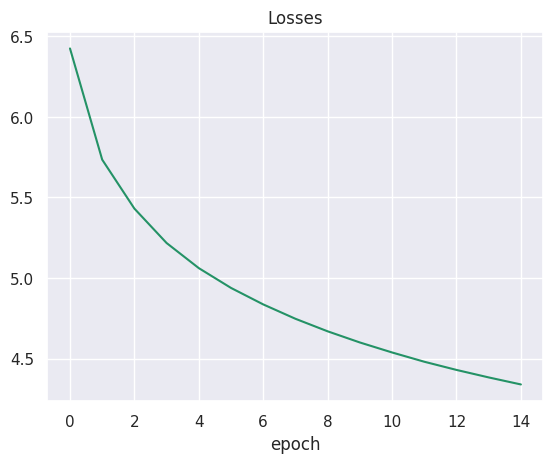

In [35]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

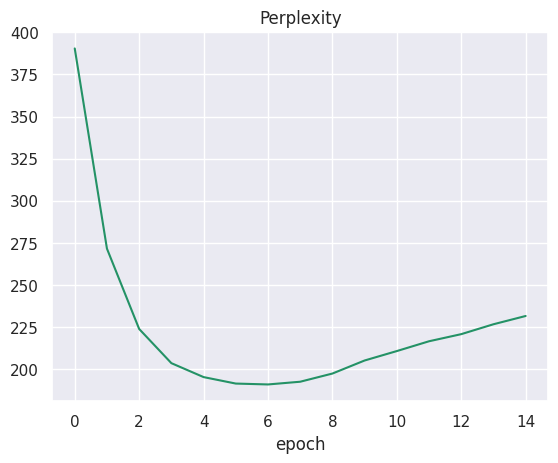

In [36]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [37]:
results = pd.DataFrame ({'model':['LanguageModel'], 'perplexities':[min(perplexities)]})
results

,model,perplexities
0,LanguageModel,190.97628


In [38]:
torch.save(model.state_dict(), 'model_LanguageModel.pth')

In [39]:
del model

### Обучим модель RNN

In [40]:
class WordRNN(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()

        # Сама нейронная сеть
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут forward pass модели
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)
        output = self.dropout(self.linear(self.non_lin(output)))
        projection = self.projection(self.non_lin(output))

        return projection

In [41]:
clean_cash()

In [42]:
model = WordRNN(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 15

In [43]:
losses, perplexities = train_model(model, train_dataloader, criterion, optimizer, num_epoch)

Training epoch 14:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 795/795 [01:53<00:00,  7.01it/s]


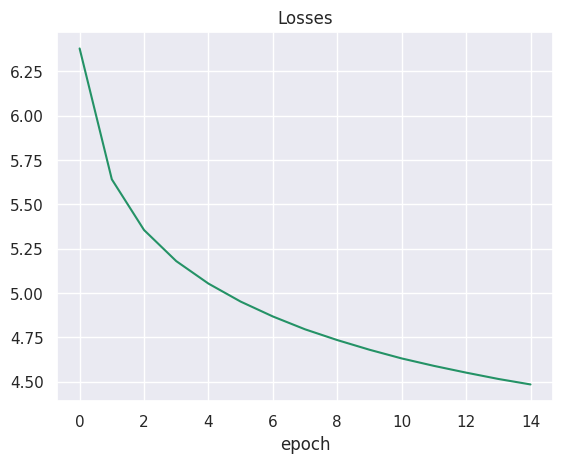

In [44]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

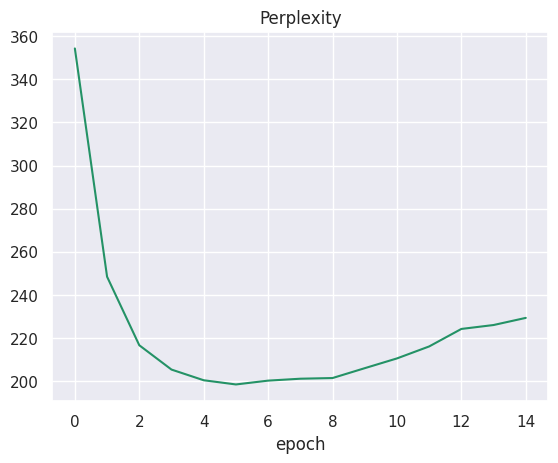

In [45]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [47]:
results = pd.concat(
    [results, pd.DataFrame({'model':['WordRNN'], 'perplexities':[min(perplexities)]})], ignore_index=True
)
results

,model,perplexities
0,LanguageModel,190.976280
1,WordRNN,198.490778


In [48]:
torch.save(model.state_dict(), 'model_WordRNN.pth')

In [49]:
del model

In [50]:
clean_cash()

### Вывод

В обоих экспериментах мы, для частоты пробы, крутили сетки по 15 эпох.
В первом эксперименте мы использовали GRU, во втором RRN.
В обоих случаях архитектура сеток по слоям, не считая архитектур самих сеток, схожа.
Изначально взял GRU, т.к. это уже не сеть прямого распространения, как RNN, у нее уже есть попытка избавиться от затухания (зврывания градиента).
GRU - разновидность LSTM. У них на один фильтр меньше, и они немного иначе соединены: вместо входного, выходного фильтров и фильтра забывания здесь используется фильтр обновления (update gate). Этот фильтр определяет сколько информации сохранить от последнего состояния и сколько информации получить от предыдущего слоя. Фильтр сброса состояния (reset gate) работает почти так же, как фильтр забывания, но расположен немного иначе. На следующие слои отправляется полная информация о состоянии — выходного фильтра здесь нет. В большинстве случаем GRU работают так же, как LSTM, самое значимое отличие в том, что GRU немного быстрее и проще в эксплуатации (однако обладает немного меньшими выразительными возможностями).
Сравнение RNN и GRU мне показалось уместным.
Осталось проверить, как они ведут себя на тестовых даннных и немного наглядности.

In [51]:
model = LanguageModel(hidden_dim=256, vocab_size=len(vocab)).to(device)
model.load_state_dict(torch.load('model_LanguageModel.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [52]:
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [53]:
perplexities = evaluate(model, criterion, test_dataloader)

In [54]:
results = pd.DataFrame ({'model':['LanguageModel'], 'test_perplexities':[perplexities]})
results

,model,test_perplexities
0,LanguageModel,228.40656


Посмотрим на предсказание

In [55]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)
    
    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break
    
    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

In [56]:
generate_sequence(model, starting_seq='It may treat important issues')

'<bos> <unk> may treat important issues as a <unk> <eos>'

Посмотрим на результат работы второй модели

In [57]:
model = WordRNN(hidden_dim=256, vocab_size=len(vocab)).to(device)
model.load_state_dict(torch.load('model_WordRNN.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [58]:
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [59]:
perplexities = evaluate(model, criterion, test_dataloader)

In [60]:
results = pd.concat(
    [results, pd.DataFrame({'model':['WordRNN'], 'test_perplexities':[perplexities]})], ignore_index=True
)
results

,model,test_perplexities
0,LanguageModel,228.406560
1,WordRNN,227.603665


In [61]:
generate_sequence(model, starting_seq='It may treat important issues')

'<bos> <unk> may treat important issues in the movie <eos>'

В обоих случаях так себе результат, но его можно улучшить сохраняя в процессе обучения веса лучшей модели, т.к. по графикам обучения видно, что сетки после 5 эпох обучения начинают вести себя неадекватно либо поиграться с гиперпараметрами, подбором оптимизатора, слоями, переходами между слоями.